[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/image/image-retrieval-ebook/vision-transformers/vit.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/image/image-retrieval-ebook/vision-transformers/vit.ipynb)

# Vision Transformers (ViT) Walkthrough

In [1]:
!pip install datasets transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Let's start by downloading the CIFAR-10 dataset from HuggingFace. We will first download the training dataset by setting ```split = 'train'```, and the testing dataset after by setting ```split = 'test'```.

In [4]:
# import CIFAR-10 dataset from HuggingFace
from datasets import load_dataset

dataset_train = load_dataset(
    'cifar10',
    split='train', # training dataset
)

dataset_train

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [5]:
dataset_test = load_dataset(
    'cifar10',
    split='test', # training dataset
)

dataset_test

Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

In [6]:
# check how many labels/number of classes
num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label']
num_classes, labels

(10,
 ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None))

*Training*: 50,000 images divided into 10 classes

*Test*: 10,000 images divided into 10 classes

In [7]:
dataset_train[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

Those are PIL images with $3$ color channels, and $32x32$ pixels resolution. Let's have a look at the first picture in the dataset.

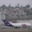

In [8]:
dataset_train[0]['img']

In [9]:
dataset_train[0]['label'], labels.names[dataset_train[0]['label']]

(0, 'airplane')

### Loading ViT Feature Extractor

We use `google/vit-base-patch16-224-in21k` model from the Hugging Face Hub.

The model is named as so as it refers to base-sized architecture with patch resolution of 16x16 and fine-tuning resolution of 224x224.  

In [10]:
from transformers import ViTFeatureExtractor

# import model
model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


You can see the feature extractor configuration by printing it

In [11]:
feature_extractor

ViTFeatureExtractor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

If we consider the first image, i.e., the airplane shown above, we can see the resulting tensor after passing the image through the feature extractor.

In [12]:
example = feature_extractor(
    dataset_train[0]['img'],
    return_tensors='pt'
)
example

{'pixel_values': tensor([[[[ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          ...,
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          ...,
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412]],

         [[ 0.4824,  0.4824,  0.4824,  ...,  0.3647,  0.3647,  0.3647],
          [ 0

In [13]:
example['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [14]:
# load in relevant libraries, and alias where appropriate
import torch

# device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(
        batch['img'],
        return_tensors='pt'
    )
    # include the labels
    inputs['label'] = batch['label']
    return inputs

We can apply this to both the training and testing dataset.

In [16]:
# transform the training dataset
prepared_train = dataset_train.with_transform(preprocess)
# ... and the testing dataset
prepared_test = dataset_test.with_transform(preprocess)

Now, whenever you get an example from the dataset, the transform will be applied in real time (on both samples and slices).

### Model Fine-Tuning

In this section, we are going to build the Trainer, which is a feature-complete training and eval loop for PyTorch, optimized for HuggingFace 🤗 Transformers.

We need to define all of the arguments that it will include:
* training and testing dataset
* feature extractor
* model
* collate function
* evaluation metric
* ... other training arguments.

The collate function is useful when dealing with lots of data. Batches are lists of dictionaries, so collate will help us create batch tensors.

In [17]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

Let's now define the evaluation metric we are going to use to compare prediction with actual labels. We will use the *accuracy evaluation metric*.

Accuracy is defined as the proportion of correct predictions (True Positive ($TP$) and True Negative ($TN$)) among the total number of cases processed ($TP$, $TN$, False Positive ($FP$), and False Negative ($FN$)).

$$Accuracy = \frac{(TP + TN)}{(TP + TN + FP + FN)}$$    

Below, we are using accuracy within the ```compute_metrics``` function.

In [23]:
import numpy as np
#! pip install evaluate
import evaluate

# accuracy metric
metric = evaluate.load("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )

The last thing consists of defining ```TrainingArguments```.

Most of these are pretty self-explanatory, but one that is quite important here is ```remove_unused_columns=False```. This one will drop any features not used by the model's call function. By default it's True because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

We have chosen a batch size equal to 16, 100 evaluation steps, and a learning rate of $2e^{-4}$.

In [35]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./cifar",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  save_steps=3125,
  eval_steps=3125,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


We can now load the pre-trained model. We'll add ```num_labels``` on init so the model creates a classification head with the right number of units.

In [36]:
from transformers import ViTForImageClassification

labels = dataset_train.features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    num_labels=len(labels)
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

We can see the characteristics of our model.

Now, all instances can be passed to ```Trainer```.

In [38]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

<ipython-input-38-d6afe72a7acd>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


We can save our trained model.

In [39]:
train_results = trainer.train()
# save tokenizer with the model
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
3125,0.148700,0.183742,0.944300
6250,0.142400,0.154735,0.955400
9375,0.034900,0.128222,0.969200
12500,0.000400,0.119379,0.976300


***** train metrics *****
  epoch                    =           4.0
  total_flos               = 14435042795GF
  train_loss               =        0.1083
  train_runtime            =    2:01:06.44
  train_samples_per_second =        27.524
  train_steps_per_second   =          1.72


#### Model Evaluation

We can now evaluate our model using the accuracy metric defined above...

In [40]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9763
  eval_loss               =     0.1194
  eval_runtime            = 0:01:55.91
  eval_samples_per_second =     86.269
  eval_steps_per_second   =     10.784


Model accuracy is pretty good. Let's have a look to an example. We can pick the first image in our testing dataset and see if the predicted label is correct.

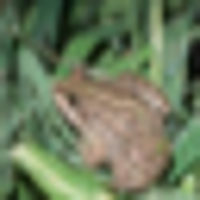

In [44]:
# show the first image of the testing dataset
image = dataset_test["img"][4].resize((200,200))
image

The image is not very clear, even when resized. Let's extract the actual label.

In [45]:
# extract the actual label of the first image of the testing dataset
actual_label = dataset_test["label"][4]

labels = dataset_test.features['label']
actual_label, labels.names[actual_label]


(6, 'frog')

It looks like the image represents a cat. Let's now see what our model has predicted. Given we saved it on the HuggingFace Hub, we first need to import it. We can use ViTForImageClassification and ViTFeatureExtractor to import the model and extract its features. We would need the predicted pixel values "pt".

In [46]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# import our fine-tuned model
model_name_or_path = 'LaCarnevali/vit-cifar10'
model_finetuned = ViTForImageClassification.from_pretrained(model_name_or_path)
# import features
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(model_name_or_path)

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [47]:
inputs = feature_extractor_finetuned(image, return_tensors="pt")

with torch.no_grad():
    logits = model_finetuned(**inputs).logits

We can now see what is our predicted label. Do extract it, we can use the argmax function.

In [48]:
predicted_label = logits.argmax(-1).item()
labels = dataset_test.features['label']
labels.names[predicted_label]

'frog'

And the answer is frog. Which is what we would expect.

## References

[Article](https://pinecone.io/learn/vision-transformers/)

[1] Dosovitskiy et al., [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929), 2021, CV.

[2] Vaswani et al., [Attention Is All You Need](https://arxiv.org/abs/1706.03762), 2017.

[3] Saeed M., [A Gentle Introduction to Positional Encoding in Transformer Models, Part 1](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/), 2022, Attention, Machine Learning Mastery.